In [1]:
import os
os.environ['PYSPARK_PYTHON']        = '/usr/local/bin/python3'
os.environ['PYSPARK_DRIVER_PYTHON'] = '/usr/local/bin/python3'
os.environ['JAVA_HOME']             = '/Library/Java/JavaVirtualMachines/jdk1.8.0_181.jdk/Contents/Home' # Java 10 is problematic

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark.sparkContext.setCheckpointDir('checkpoint/') # https://stackoverflow.com/a/31484461

In [3]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.types import *
from random import randint, uniform
from multiprocessing.dummy import Pool, Process # dummy means threads, not real processes

In [4]:
from helpers import make
# from helpers_my import make

In [5]:
ratings = make('ratings', spark=spark)
ratings.show(10)

+----+-----+------+
|user|movie|rating|
+----+-----+------+
|   1|    1|   4.0|
|   1|    3|   4.0|
|   1|    6|   4.0|
|   1|   47|   5.0|
|   1|   50|   5.0|
|   1|   70|   3.0|
|   1|  101|   5.0|
|   1|  110|   4.0|
|   1|  151|   5.0|
|   1|  157|   5.0|
+----+-----+------+
only showing top 10 rows



In [6]:
param_fixed = {
    'userCol'          : 'user'  , 
    'itemCol'          : 'movie' ,
    'ratingCol'        : 'rating',
    'coldStartStrategy': 'drop'  ,
    'nonnegative'      : True    ,
    'implicitPrefs'    : True    ,
    'maxIter'          : 20      ,
}

In [7]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

In [8]:
def evaluate_params(params, model_class, param_fixed, evaluator, ratings):
    train, test = ratings.randomSplit([0.8, 0.2])
    model = model_class(**params, **param_fixed)
    predictions = model.fit(train).transform(test)
    return evaluator.evaluate(predictions)

def cv(params):
    cv_folds = 3
    func = lambda params: evaluate_params(
        params      = params     ,
        model_class = ALS        ,
        param_fixed = param_fixed,
        evaluator   = evaluator  ,
        ratings     = ratings    ,
    )
    score = sum(Pool(processes=cv_folds).map(func=func, iterable=[params]*cv_folds)) / cv_folds
    if score < best['score']:
        best['params'] = params
        best['score' ] = score
        print('new best params found:', best)
        with open('best_params.py', 'a') as f:
            f.write('best = ' + str(best) + '\n')
    return (params, score)

In [9]:
param_search_config = {
    'rank'    : {'range': (4    , 12 ), 'dtype': int  },
    'regParam': {'range': (0.001, 0.4), 'dtype': float},
    'alpha'   : {'range': (1.0  , 60 ), 'dtype': float},
}

iterations = 3

best = {'params': None, 'score': float('inf')}
open('best_params.py', 'w').close()

pool = []
for i in range(iterations):
    p = {}
    for param, config in param_search_config.items():
        if config['dtype'] is int:
            rand_func = randint
        if config['dtype'] is float:
            rand_func = uniform
        p[param] = rand_func(config['range'][0], config['range'][1])
    thread = Process(target=cv, args=(p,))
    pool.append(thread)
    thread.start()
    
for thread in pool:
    thread.join()

new best params found: {'params': {'rank': 9, 'regParam': 0.33405918369641924, 'alpha': 55.54248443560661}, 'score': 2.842203926755699}


# Prediction using best params

In [10]:
param_fixed = {
    'userCol'          : 'user'  , 
    'itemCol'          : 'movie' ,
    'ratingCol'        : 'rating',
    'coldStartStrategy': 'drop'  ,
    'nonnegative'      : True    ,
    'implicitPrefs'    : True    ,
    'maxIter'          : 100     ,
}

In [11]:
best_params = best['params']
train, test = ratings.randomSplit([0.8, 0.2])
predictions = ALS(**best_params, **param_fixed).fit(train).transform(test)

In [12]:
rating_pred = predictions.rdd.map(lambda x: x.prediction).collect()
rating_true = predictions.rdd.map(lambda x: x.rating    ).collect()

In [13]:
import matplotlib.pyplot as plt
import numpy as np

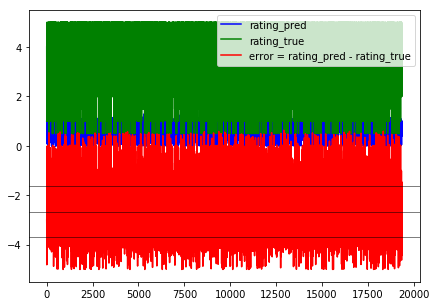

In [14]:
error = np.array(rating_pred) - np.array(rating_true)
mean = error.mean()
std  = error.std() 

plt.figure(figsize=(7, 5))
plt.plot(rating_pred, color='blue' , label='rating_pred')
plt.plot(rating_true, color='green', label='rating_true')
plt.plot(error, color='red', label='error = rating_pred - rating_true')
plt.axhline(mean      , color='k', lw=0.5)
plt.axhline(mean - std, color='k', lw=0.5)
plt.axhline(mean + std, color='k', lw=0.5)
plt.legend(loc=1)

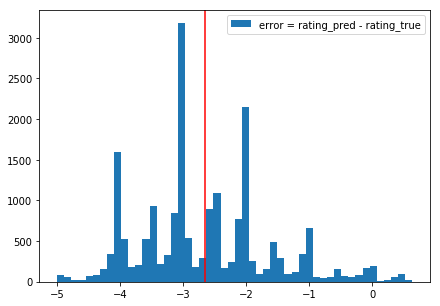

In [15]:
plt.figure(figsize=(7, 5))
plt.hist(error, bins=50, label='error = rating_pred - rating_true')
plt.axvline(x=mean, color='red')
plt.legend(loc=1)